# K-means кластеризация

### Описание алгоритма 
1. Arbitrarily choose an initial $k$ centers $C=\{c_1, c_2,···, c_k\}$.
2. For each $i \in \{1, . . . , k\}$, set the cluster $C_i$ to be the set of points in $X$ that are closer to $c_i$ than they are to $c_j$ for all $j\neq i$.
3. For each $i \in \{1, . . . , k\}$, set $c_i$ to be the center of mass of all points in $C_i: c_i=\frac{1}{|C_i|} \sum_{x \in C_i}{x}$.
4. Repeat Steps 2 and 3 until $C$ no longer changes.

### Импортируем нужные библиотеки
Pandas - для удобной работы с данными, matplotlib - для визуализации, numpy - для математики

In [1]:
import pandas as pd
import numpy as np
import random
import pylab as pl
import matplotlib.pyplot as plt

### Cчитаем данные в DataFrame

In [2]:
data = pd.read_csv('4ClustersTest.csv', index_col=0)
#вывести пять случайных строк таблицы
data.sample(10)

,x,y
1422,-1.873317,8.013264
1262,-2.641019,7.707003
2828,1.255668,3.382041
1170,-1.347903,3.052753
1932,1.741720,0.713385
596,1.834206,1.190935
3162,0.744148,3.997612
1283,-0.583173,7.618879
853,-0.055106,1.793702
2323,-1.434062,2.391165


In [3]:
dataset = [(float(data['x'][i]), float(data['y'][i])) for i in range(1,len(data.index)+1)]

### K-means++ 
Суть улучшения заключается в нахождении более «хороших» начальных значений центроидов кластеров:
1. Выбрать первый центроид случайным образом (среди всех точек)
2. Для каждой точки найти значение квадрата расстояния до ближайшего центроида (из тех, которые уже выбраны) dx²
3. Выбрать из этих точек следующий центроид так, чтобы вероятность выбора точки была пропорциональна вычисленному для неё квадрату расстояния. Это можно сделать следующим образом. На шаге 2 нужно параллельно с расчётом dx² подсчитывать сумму Sum(dx²). После накопления суммы найти значение Rnd=random(0.0,1.0)*Sum. Rnd случайным образом укажет на число из интервала [0; Sum), и нам остаётся только определить, какой точке это соответствует. Для этого нужно снова начать подсчитывать сумму S(dx²) до тех пор, пока сумма не превысит Rnd. Как только это случится, суммирование останавливается, и мы можем взять текущую точку в качестве центроида.
При выборе каждого следующего центроида специально следить за тем, чтобы он не совпал с одной из уже выбранных в качестве центроидов точек, не нужно, так как вероятность повторного выбора некоторой точки равна 0.
4. Повторять шаги 2 и 3 до тех пор, пока не будут найдены все необходимые центроиды.

In [4]:
# Функция для нахождения центроид по алгоритму k-means++
def plusplus(data, k): 
#     выбираем первый центроид случайным образом из всех точек
    random_index = random.randint(0, len(data) - 1)
#     инициализируем список c для хранения центроид 
    c = []
    c.append(data[random_index])
#     до тех пора, пока не будут найдены все необходимые центроиды
#     поскольку одна центроида - случайная, нужно найти ещё (k-1) центроиду
    while (k-1) > 0: 
        dx2 = []
#         для всех точек в датасете
        for point in data:
#             инициализируем список для хранения квадратов расстояний от i-й точки до всех центроид
            euclidean_dist = []
            for cent in c:
#                 считаем квадрат евклидова расстояния 
                dist = (cent[0] - point[0]) ** 2 + (cent[1] - point[1])**2
                euclidean_dist.append(dist)
#             в список расстояний добавляем расстояние до ближайшей центроиды
            dx2.append(min(euclidean_dist))
#         находим сумму расстояний
        Sum = np.sum(dx2)
#         случайное число из интервала [0;Sum)
        Rnd = random.random()*Sum
        Sum_new = -1
#         пересчитываем сумму расстояний
        for i in range(len(dx2)):
#             до тех пор, пока не превысит найденное случайное число
            if Sum_new <= Rnd:
                Sum_new += dx2[i]
            else: 
#                 когда превысит - берем текущую точку в качестве следующего центроида
                c.append(data[i])
                break 
        k -= 1
    return c

In [5]:
# Функция для нахождения центроид - двух случайных точек из выборки
def rand_cent(data, k): 
    c = []
    for _ in range(k):
        random_index = random.randint(0, len(data) - 1)
        c.append(data[random_index])
        data.pop(random_index)
    return c

### Реализация K-Means Clustering  

In [6]:
# На вход принимаем данные из датасета, функцию для начальных значений центроид и число кластеров
def k_means_clustering (data, initial, k):
    c_old = []
    c = initial(data,k)
#     пока центроиды отличаются
    while c != c_old: 
        c_old = c
        answers = []
#         проходимся по точкам и считаем евклидово расстояние
        for point in data:
            euclidean_dist = []
            for cent in c:  
                dist = ((cent[0] - point[0]) ** 2 + (cent[1] - point[1]) ** 2) ** (1/2)
                euclidean_dist.append(dist) 
#             В столбец ответов записываем индекс массива - с расстояниями от точки до центроид
#             с наименьшим значением расстояния. Это будет названием класса для точки. 
            answers.append(np.argmin(euclidean_dist))
#         обновляем значение центроид
        c = []
#         проходим по классам
        for i in range(k): 
            sum = [0,0]  
#             пробегаем по строкам с точками
            for j in range(len(answers)): 
#                 если значение из класса, который мы сейчас рассматриваем - прибавляем к сумме
                if answers[j] == i: 
                    sum[0] += data[j][0] 
                    sum[1] += data[j][1]
#             находим итоговое значение новых центроид
            c.append([1/answers.count(i)*sum[0],1/answers.count(i)*sum[1]])
    return c, answers          

In [7]:
def plot(data, cent, ans):
    color_Value = ['y', 'g', 'b', 'c', 'k', 'm']
    for cluster_index in range(len(set(ans))):
        coordinate_X = []    
        coordinate_Y = []
        for i in range(len(ans)): 
            if ans[i] == cluster_index:
                coordinate_X.append(data[i][0])
                coordinate_Y.append(data[i][1])
        pl.scatter(coordinate_X, coordinate_Y, marker='o', color=color_Value[cluster_index%len(color_Value)])
        pl.plot(cent[cluster_index][0],cent[cluster_index][1],marker='o',color = 'r')
    pl.show()

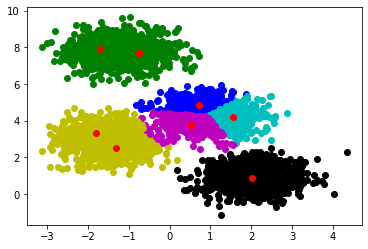

In [8]:
# centroids, answer = k_means_clustering(dataset,plusplus,2)
centroids, answer = k_means_clustering(dataset,rand_cent,8)
plot(dataset,centroids, answer)